In [1]:
#%pip install matplotlib numpy torch scikit-learn tqdm pandas  emnist torchvision

In [1]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/3h6h5d7xg2-2.zip -O RussianHandwritingsTracked.zip

--2024-02-04 18:33:07--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/3h6h5d7xg2-2.zip
Распознаётся prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)… 52.92.19.122, 52.218.106.200, 52.92.36.210, ...
Подключение к prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.19.122|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 9370403 (8,9M) [application/zip]
Сохранение в: «RussianHandwritingsTracked.zip»

RussianHandwritings 100%[===================>]   8,94M  2,94MB/s    за 3,0s    

2024-02-04 18:33:11 (2,94 MB/s) - «RussianHandwritingsTracked.zip» сохранён [9370403/9370403]



In [2]:
!unzip -o RussianHandwritingsTracked.zip 

Archive:  RussianHandwritingsTracked.zip
  inflating: Russian Handwritings Tracked/russian_handwritings_tracked.zip  


In [3]:
!ls "Russian Handwritings Tracked/russian_handwritings_tracked.zip"

'Russian Handwritings Tracked/russian_handwritings_tracked.zip'


In [ ]:
!unzip -o "Russian Handwritings Tracked/russian_handwritings_tracked.zip" -d "Russian Handwritings Tracked/"

In [5]:
import sys
import os
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import PIL
from PIL import Image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import time
import copy
from IPython.display import clear_output

In [6]:
import os
from tqdm import tqdm
labels=np.array([])
images=np.array([])
CHAR_LIST = ['А','а','Б','б','В','в','Г','г','Д','д','Е','е','Ё','ё','Ж','ж','З','з',
        'И','и','Й','й','К','к','Л','л','М','м','Н','н','О','о','П','п','Р','р',
        'С','с','Т','т','У','у','Ф','ф','Х','х','Ц','ц','Ч','ч','Ш','ш','Щ','щ',
        'Ъ','ъ','Ы','ы','Ь','ь','Э','э','Ю','ю','Я','я','0','1','2','3','4','5',
        '6','7','8','9']
writers = list()
subfolders = [ f.path for f in os.scandir("new") if f.is_dir()]
for w in subfolders:
    if w == ".": continue
    writer_name = ''.join([i for i in w if not i.isdigit()])
    if writer_name not in writers: writers.append(writer_name)
    for i in tqdm(range(len(CHAR_LIST))):
        fn=w+"/mnist-like/"+CHAR_LIST[i]+".csv"
        img=pd.read_csv(fn,header=None) 
        labels=np.append(labels,i)        
        images=np.append(images,np.array(img.values))
images=images.reshape(-1,28,28)

100%|██████████| 76/76 [00:00<00:00, 206.38it/s]


In [7]:
print(len(CHAR_LIST))

76


In [8]:
class Digits:
    def __init__(self):
        p = np.random.permutation(len(images))
        self.images=images[p]
        self.target=labels[p]
        self.classes=CHAR_LIST
rus_digits=Digits()

In [9]:
len(rus_digits.images)

2812

In [27]:
len(rus_digits.classes)

76

# EMNIST

In [10]:
from emnist import list_datasets

In [11]:
CHAR_LIST="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
print(len(CHAR_LIST))

62


In [12]:
from emnist import extract_training_samples
images, labels = extract_training_samples('byclass')
images.shape

(697932, 28, 28)

In [13]:
class Digits:
    def __init__(self):
        p = np.random.permutation(len(images))
        self.images=images[p]
        self.target=labels[p]
        self.classes=CHAR_LIST
emnist_digits=Digits()

# LENET

In [14]:
BATCH_SIZE=50
DATASET_VARIANT ="emnist" # "emnist"   "rus"
digits=emnist_digits # emnist_digits   rus_digits
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/jupyter_venvs/Article10_venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
len(digits.target)

697932

In [16]:

class ImageDataset(Dataset):

    def __init__(self, data, transform=None,start=None,end=None):
        if start is None:
            start=0
            end=len(data.target)
        self.data=np.array(data.images[start:end])
        self.target=np.array(data.target[start:end],dtype=np.uint8)
        self.data=self.data.reshape(-1,28,28)        
        self.classes=data.classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img=self.data[idx]
        array = np.array(img)
        img = Image.fromarray(array)
        if self.transform:
            img = self.transform(img)
        return img,self.target[idx]  

In [17]:
pivot=int(len(digits.target)*0.8)
end=len(digits.target)

In [18]:
digits
    
image_datasets = {"train": ImageDataset(digits,transform=transforms.Compose([
                                                                    # transforms.RandomRotation(degrees=(-10,10)),
                                                                    transforms.ToTensor()]),start=0,end=pivot),
                 "val":ImageDataset(digits,transform=transforms.Compose([
                                                                    # transforms.RandomRotation(degrees=(-10,10)),
                                                                    transforms.ToTensor()]),start=300,end=370)}
dataloaders = {"train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(image_datasets["val"], batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes_names = {x: image_datasets[x].classes for x in ['train', 'val']}

In [19]:
len(image_datasets["train"].target)

558345

torch.Size([3, 212, 242])


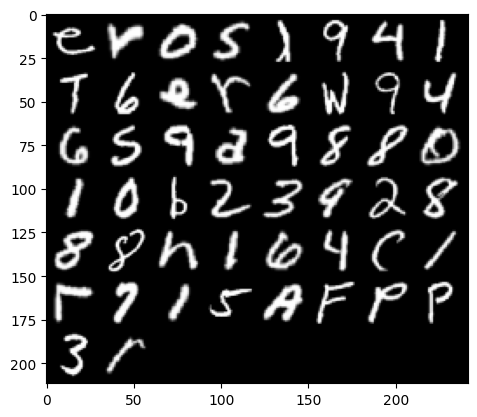

    e     r     0     S     l     9     4     l     T     6     e     r     6     W     9     4     6     S     9     a     9     8     8     O     1     0     b     2     3     9     2     8     8     8     h     1     6     4     c     1     r     7     l     5     A     F     P     P     3     r


In [20]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig("images/"+DATASET_VARIANT+"_images.png",  bbox_inches='tight', pad_inches=0)
    plt.show()

# Get a batch of training data
image, label = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(image)
print(out.shape)
imshow(torchvision.utils.make_grid(out))
str_=' '.join('%5s' % image_datasets['val'].classes[label[j]] for j in range(BATCH_SIZE))
print(str_)
with open("images/"+DATASET_VARIANT+"_images_lbl.txt", 'w') as f:
    f.write(str_)

In [21]:
class Trainer():

    @staticmethod
    def train_model(model, dtloaders, criterion, optimizer, scheduler, num_epochs=30, net_name="none"):
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
        hist_loss_train = []; hist_acc_train = [] 
        hist_loss_val = []; hist_acc_val = []

        for epoch in range(num_epochs):    # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0            
                for inputs, labels in dtloaders[phase]:    # Iterate over data.
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs,labels)
                        if phase == 'train':     # backward + optimize only if in training phase
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / len(dtloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dtloaders[phase].dataset)
                if phase == 'train':
                    hist_loss_train.append(epoch_loss)
                    hist_acc_train.append(epoch_acc.cpu().item())
                else:     
                    hist_loss_val.append(epoch_loss)
                    hist_acc_val.append(epoch_acc.cpu().item())
                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_acc = epoch_acc.item()
                    best_loss = epoch_loss
                    best_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
            clear_output(True)   
            plt.plot(hist_loss_train,label='hist_loss_train ({})'.format(round(hist_loss_train[-1],2)))
            plt.plot(hist_loss_val,label='hist_loss_val ({})'.format(round(hist_loss_val[-1],2)))
            plt.legend(framealpha=1, frameon=True);
            plt.title('Loss (epoch {}/{})'.format(epoch,num_epochs))
            plt.xlabel('эпохи')
            plt.ylabel('потери')
            plt.savefig("images/"+net_name+"_loss.png",  bbox_inches='tight', pad_inches=0)
            plt.show()
        model.eval()
        plt.plot(hist_acc_train,label='hist_acc_train')
        plt.plot(hist_acc_val,label='hist_acc_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.xlabel('эпохи')
        plt.ylabel('точность')
        plt.savefig("images/"+net_name+"_acc.png",  bbox_inches='tight', pad_inches=0)
        plt.show()
        model.load_state_dict(best_model_wts)     # load best model weights
        return model,best_acc


trainer = Trainer()

In [22]:
class LeNet(nn.Module):

    def __init__(self,num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet(num_classes=len(image_datasets["train"].classes)).to(device)
if __name__ == "__main__": print(lenet)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(lenet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
start = time.time()
model,acc=trainer.train_model(lenet, dataloaders,criterion, optimizer_ft, exp_lr_scheduler, 
                      num_epochs=10,net_name="lenet_"+DATASET_VARIANT)
end = time.time()
print("Train time:{}".format(end - start))
print("Best acc:{}".format(acc))
with open("images/lenet_"+DATASET_VARIANT+"_metrics.txt", 'w') as f:
    f.write(str(acc))

## Additional materials 
Example EMNIST-like char 'a'

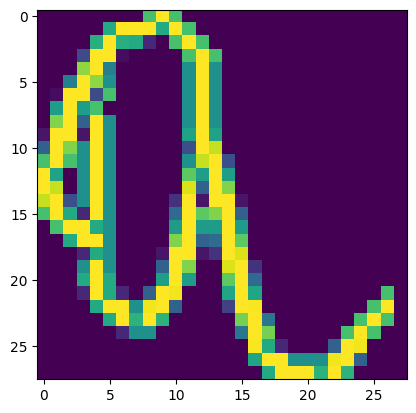

In [4]:
img=pd.read_csv('images/а.csv',header=None) 
plt.imshow(img)
plt.savefig("images/a_mnist_like.png",  bbox_inches='tight', pad_inches=0)